# Show data about public Xatu data contributors
See .env.example to set the environment variables.

In [1]:
!pip install jupysql clickhouse_sqlalchemy matplotlib python-dotenv pandas seaborn > /dev/null 2>&1

In [2]:
import dotenv
import os
from datetime import datetime

dotenv.load_dotenv()

# Load and display config
start_date = os.getenv('START_DATE_TIME')
if not start_date:
    raise ValueError("START_DATE_TIME environment variable is required")

end_date = os.getenv('END_DATE_TIME')
if not end_date:
    end_date = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")

network = os.getenv('NETWORK')

print(f"start_date: {start_date}")
print(f"end_date: {end_date}")

# Convert start and end dates to datetime objects
try:
    start_dt = datetime.fromisoformat(start_date.replace("Z", "+00:00"))
except ValueError as e:
    raise ValueError(f"Invalid start date format. Date must be in ISO format. Error: {str(e)}")

try:
    if isinstance(end_date, datetime):
        end_dt = end_date
    else:
        end_dt = datetime.fromisoformat(str(end_date).replace("Z", "+00:00"))
except ValueError as e:
    raise ValueError(f"Invalid end date format. Date must be in ISO format. Error: {str(e)}")

# Calculate the difference in hours
hours = (end_dt - start_dt).total_seconds() / 3600

print(f"hours: {hours}")


start_date: 2024-10-04T22:00:00Z
end_date: 2024-11-01T15:34:46Z
hours: 665.5794444444444


In [3]:
# Connect to ClickHouse
import os
username = os.getenv('XATU_CLICKHOUSE_USERNAME')
password = os.getenv('XATU_CLICKHOUSE_PASSWORD')
host = os.getenv('XATU_CLICKHOUSE_HOST')


db_url = f"clickhouse+http://{username}:{password}@{host}:443/default?protocol=https"

from sqlalchemy import create_engine

engine = create_engine(db_url)

connection = engine.connect()

In [4]:
from sqlalchemy import text

query = text("""
    SELECT
        toDate(slot_start_date_time) as time,
        extract(meta_client_name, '.*/([^/]+)/hashed-[0-9a-f]+') AS user,
        meta_network_name,
        uniqExact(meta_client_name) AS total
    FROM beacon_api_eth_v1_events_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name NOT LIKE 'ethpandaops%'
        AND user != ''
    GROUP BY time, user, meta_network_name
""")

result = connection.execute(query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
users = result.fetchall()

if len(users) == 0:
    raise ValueError("No users found for the given time range")

print(f"Found {len(users)} users for the given time range")




Found 286 users for the given time range


<Figure size 2100x1500 with 0 Axes>

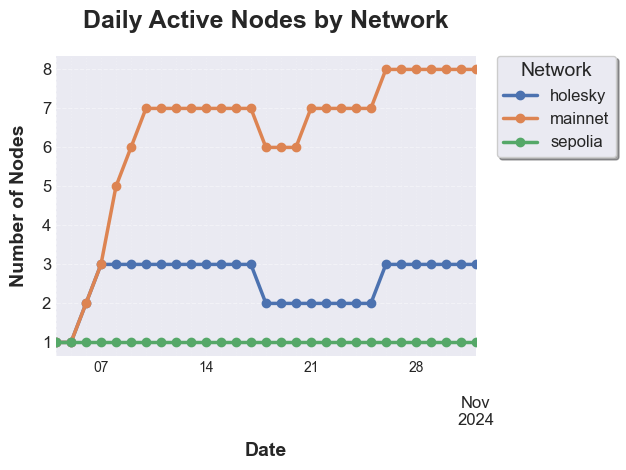

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set modern style and color palette
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("deep")

# Convert results to DataFrame and prepare data
df = pd.DataFrame(users, columns=['time', 'user', 'network', 'total'])
df['time'] = pd.to_datetime(df['time'])

# Create high resolution figure
plt.figure(figsize=(14, 10), dpi=150)

# Plot data with enhanced styling
pivot_df = df.groupby(['time', 'network'])['user'].nunique().unstack(fill_value=0)
ax = pivot_df.plot(kind='line', marker='o', markersize=6, linewidth=2.5)

# Add sophisticated styling
plt.title('Daily Active Nodes by Network', pad=20, fontsize=18, fontweight='bold', 
         fontfamily='sans-serif')
plt.xlabel('Date', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Number of Nodes', fontsize=14, fontweight='bold', labelpad=10)

# Style the axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=12)

# Enhance legend with custom styling
plt.legend(title='Network', 
          title_fontsize=14,
          fontsize=12,
          bbox_to_anchor=(1.05, 1),
          loc='upper left',
          borderaxespad=0,
          frameon=True,
          fancybox=True,
          shadow=True)

# Add refined grid
plt.grid(True, linestyle='--', alpha=0.4, which='major')
plt.grid(True, linestyle=':', alpha=0.2, which='minor')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [6]:
from sqlalchemy import text

query = text("""
    SELECT
        toDate(slot_start_date_time) as time,
        meta_consensus_implementation as client,
        meta_network_name,
        count(distinct meta_client_name) AS total
    FROM beacon_api_eth_v1_events_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name NOT LIKE 'ethpandaops%'
        AND meta_network_name = 'mainnet'
        AND meta_client_name != ''
        AND meta_client_name IS NOT NULL
    GROUP BY time, client, meta_network_name
""")

result = connection.execute(query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
clients = result.fetchall()

if len(clients) == 0:
    raise ValueError("No clients found for the given time range")

print(f"Found {len(clients)} clients for the given time range")




Found 116 clients for the given time range


NameError: name 'DateFormatter' is not defined

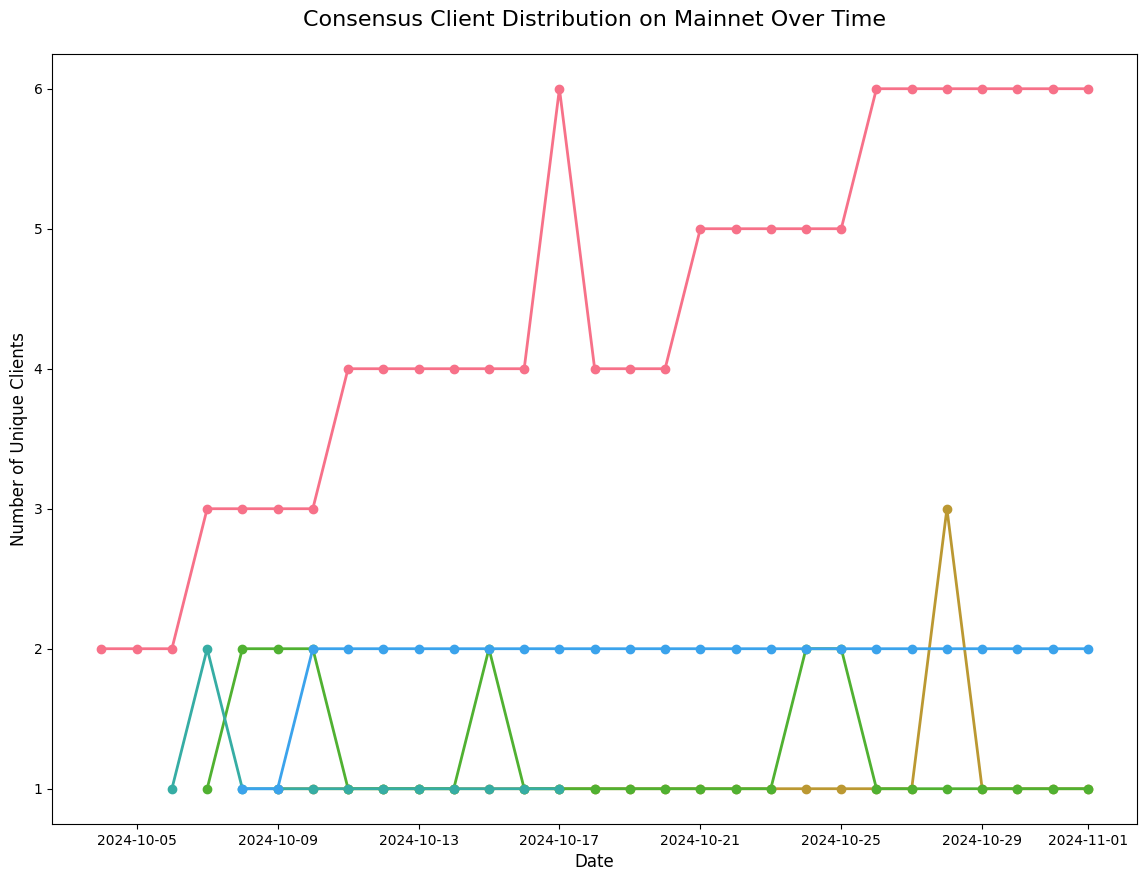

In [7]:
from matplotlib.dates import DateFormatter, DayLocator

# Convert to pandas DataFrame for easier manipulation
df = pd.DataFrame(clients, columns=['time', 'client', 'network', 'total'])

# Sort by time to ensure proper line plotting
df = df.sort_values('time')

# Create a figure with a specific size
plt.figure(figsize=(14, 10))

# Create a line plot for each client
for client in sorted(df['client'].unique()):
    client_data = df[df['client'] == client].copy()
    # Ensure data is sorted chronologically
    client_data = client_data.sort_values('time')
    plt.plot(client_data['time'], client_data['total'], marker='o', label=client, linewidth=2, markersize=6)

# Customize the plot
plt.title('Consensus Client Distribution on Mainnet Over Time', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Unique Clients', fontsize=12)

# Format x-axis with appropriate time intervals
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(DayLocator())
plt.xticks(rotation=45, ha='right')

# Add legend
plt.legend(title='Client', 
          title_fontsize=12,
          fontsize=10,
          bbox_to_anchor=(1.05, 1), 
          loc='upper left',
          borderaxespad=0)

# Customize grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add some padding around the plot
plt.tight_layout()

# Show the plot
plt.show()


In [69]:
from sqlalchemy import text

query = text("""
    SELECT
        toDate(slot_start_date_time) as time,
        meta_client_geo_country as country,
        meta_network_name,
        count(distinct meta_client_name) AS total
    FROM beacon_api_eth_v1_events_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name NOT LIKE 'ethpandaops%'
        AND meta_network_name = 'mainnet'
        AND meta_client_name != ''
        AND meta_client_name IS NOT NULL
    GROUP BY time, country, meta_network_name
""")

result = connection.execute(query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
countries = result.fetchall()

if len(clients) == 0:
    raise ValueError("No clients found for the given time range")

print(f"Found {len(countries)} countries for the given time range")




Found 115 countries for the given time range


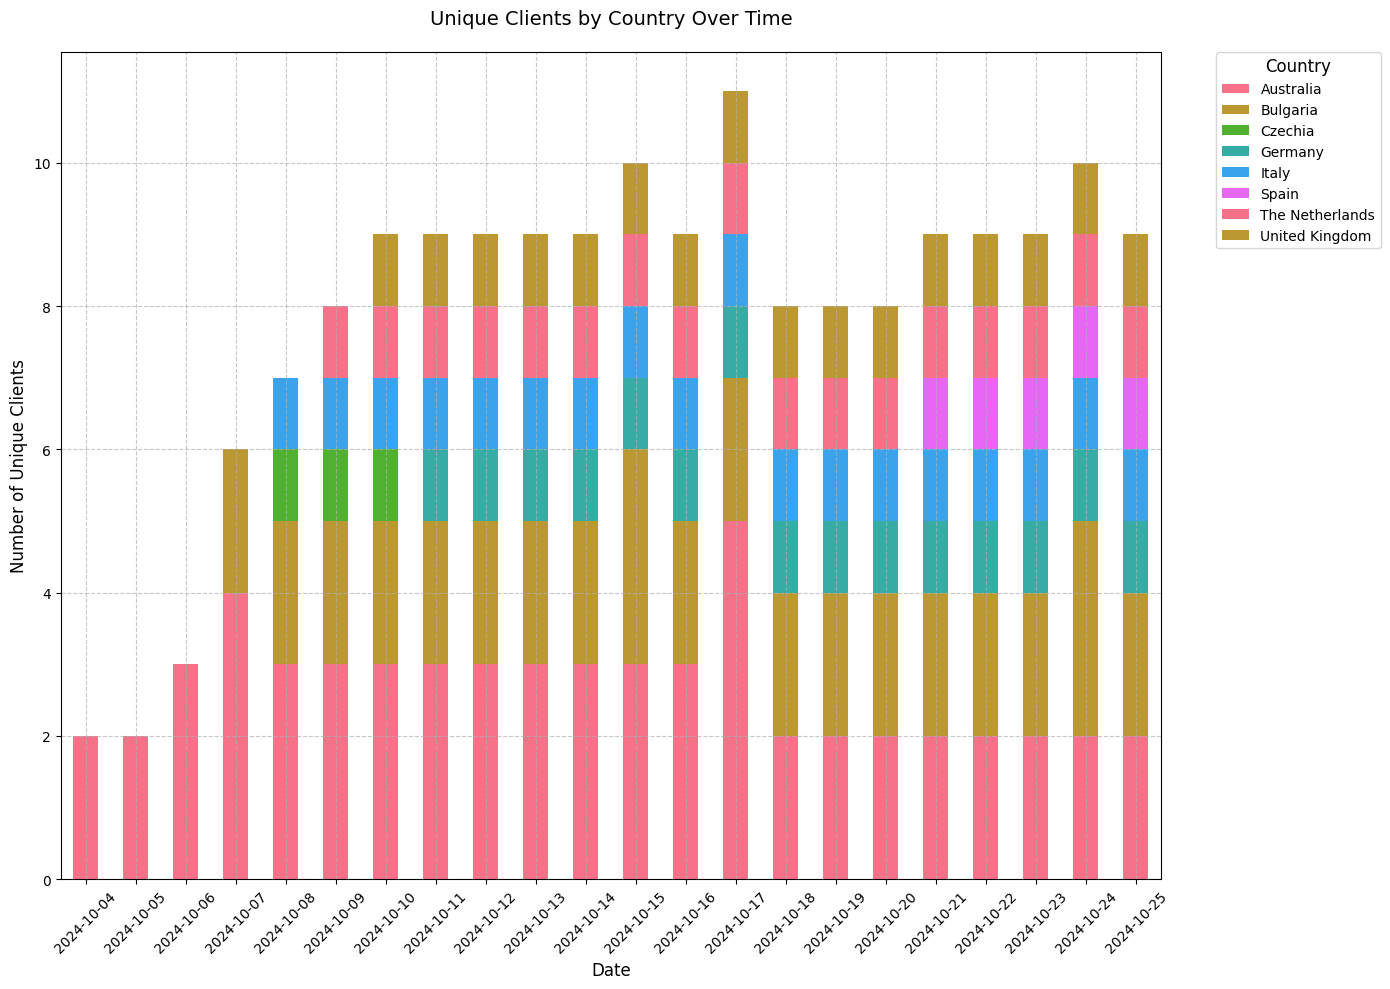

In [70]:
# Convert the results to a pandas DataFrame
df = pd.DataFrame(countries, columns=['time', 'country', 'meta_network_name', 'total'])

# Create the plot
plt.figure(figsize=(14, 10))

# Plot stacked bars for each country
df_pivot = df.pivot(index='time', columns='country', values='total')
df_pivot.plot(kind='bar', stacked=True, ax=plt.gca())

# Customize the plot
plt.title('Unique Clients by Country Over Time', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Unique Clients', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend(title='Country',
          title_fontsize=12,
          fontsize=10, 
          bbox_to_anchor=(1.05, 1),
          loc='upper left',
          borderaxespad=0)

# Customize grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add some padding around the plot
plt.tight_layout()

# Show the plot
plt.show()


In [57]:
from sqlalchemy import text

query = text("""
    SELECT
        meta_client_geo_country as countries
    FROM beacon_api_eth_v1_events_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name NOT LIKE 'ethpandaops%'
        AND meta_network_name = 'mainnet'
    GROUP BY countries
""")

result = connection.execute(query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
distinct_countries = result.fetchall()

if len(distinct_countries) == 0:
    raise ValueError("No distinct countries found for the given time range")

print(f"Found {len(distinct_countries)} distinct countries for the given time range")


Found 8 distinct countries for the given time range


In [63]:

query = text("""
    SELECT
        slot_start_date_time as time,
        min(propagation_slot_start_diff) as arrival_time,
        meta_client_geo_country as country
    FROM beacon_api_eth_v1_events_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name NOT LIKE 'ethpandaops%'
        AND meta_client_name != ''
        AND meta_client_name IS NOT NULL
        AND meta_network_name = 'mainnet'
    GROUP BY time, country, slot
""")

result = connection.execute(query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
country_arrival_times = result.fetchall()

if len(country_arrival_times) == 0:
    raise ValueError("No country arrival times found for the given time range")

print(f"Found {len(country_arrival_times)} country arrival times for the given time range")


Found 743433 country arrival times for the given time range


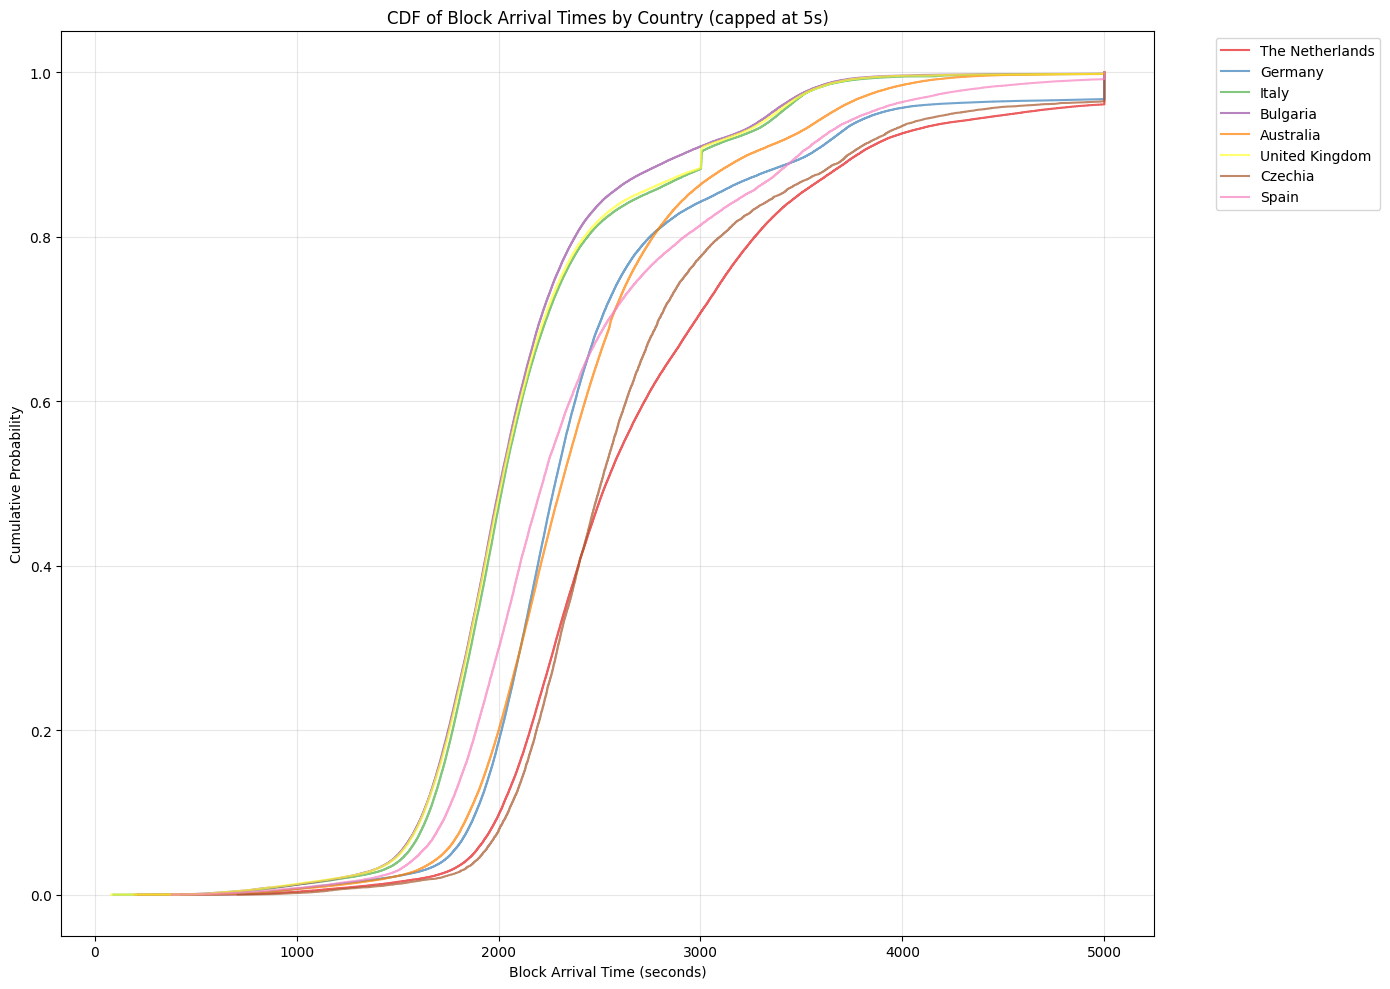

In [73]:
# Import numpy
import numpy as np

# Convert results to pandas DataFrame and use the country_arrival_times data
df = pd.DataFrame(country_arrival_times)

# Create a figure with a larger size
plt.figure(figsize=(14, 10))

# Define a distinct color palette
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', 
          '#a65628', '#f781bf', '#999999', '#66c2a5', '#fc8d62', '#8da0cb',
          '#e78ac3', '#a6d854', '#ffd92f']

# Calculate and plot CDF for each country
for i, country in enumerate(df['country'].unique()):
    # Get arrival times for this country and cap at 5 seconds
    country_data = df[df['country'] == country]['arrival_time'].clip(upper=5000)
    
    # Sort the data
    sorted_data = np.sort(country_data)
    
    # Calculate cumulative probabilities
    cumulative_prob = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    
    # Plot CDF with distinct color
    plt.plot(sorted_data, cumulative_prob, label=country, alpha=0.7, 
             color=colors[i % len(colors)])

plt.grid(True, alpha=0.3)
plt.xlabel('Block Arrival Time (seconds)')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Block Arrival Times by Country (capped at 5s)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add some padding around the plot
plt.tight_layout()

# Show the plot
plt.show()


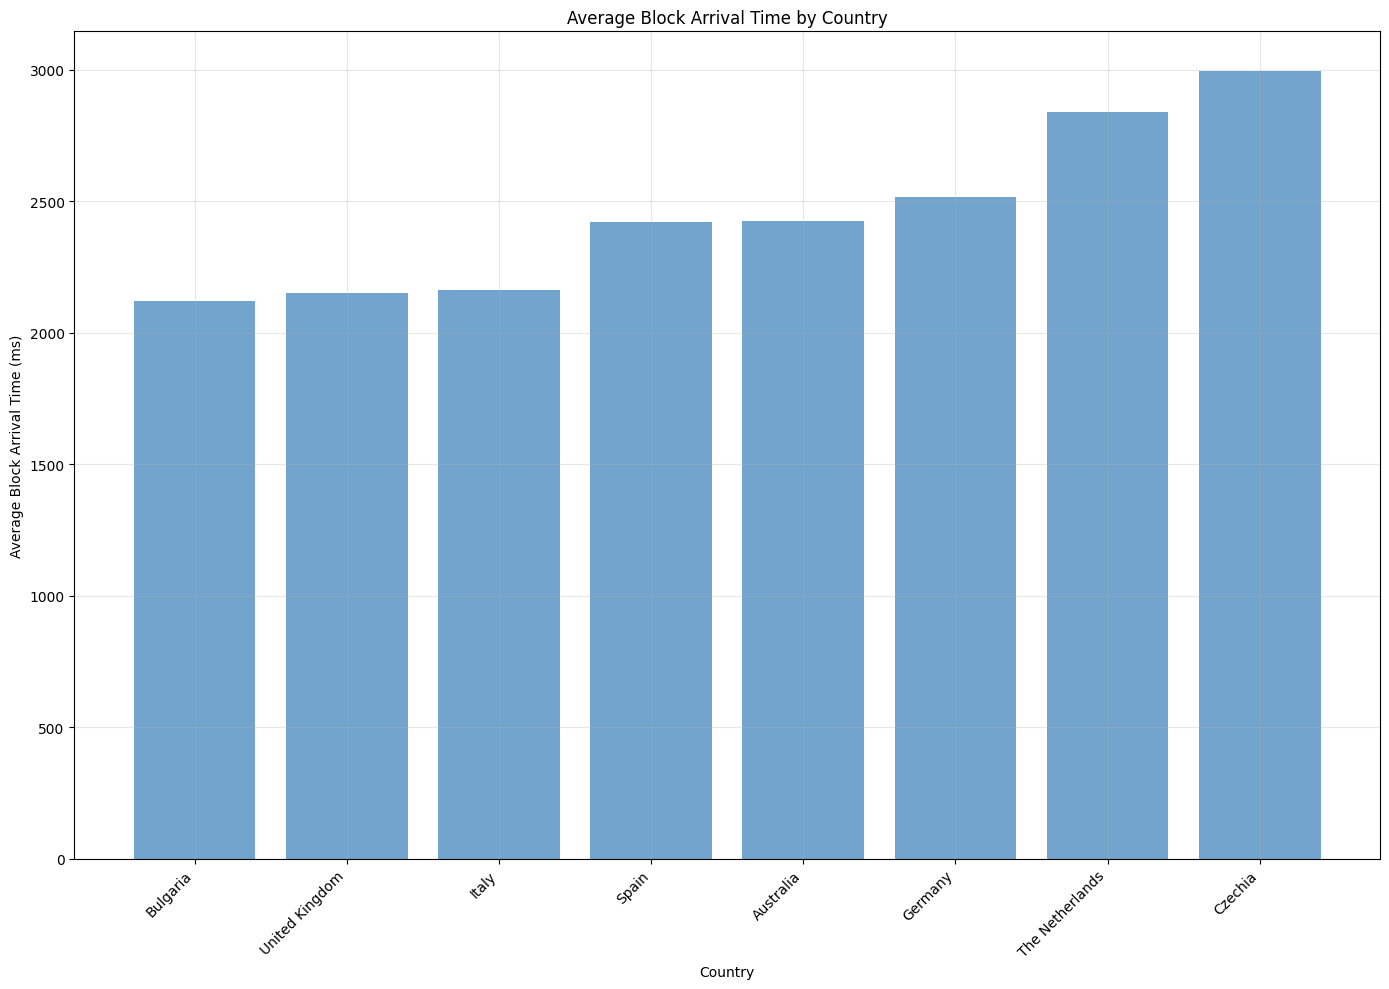

In [74]:
# Convert results to pandas DataFrame
df = pd.DataFrame(country_arrival_times)

# Create a figure with a larger size
plt.figure(figsize=(14, 10))

# Calculate average arrival time per country
avg_arrival_times = df.groupby('country')['arrival_time'].mean().sort_values(ascending=True)

# Create bar plot
plt.bar(range(len(avg_arrival_times)), avg_arrival_times.values, color='#377eb8', alpha=0.7)

# Customize the plot
plt.xticks(range(len(avg_arrival_times)), avg_arrival_times.index, rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.xlabel('Country')
plt.ylabel('Average Block Arrival Time (ms)')
plt.title('Average Block Arrival Time by Country')

# Add some padding around the plot
plt.tight_layout()

# Show the plot
plt.show()


In [67]:
# Query for block events
block_query = text("""
    SELECT
        slot_start_date_time as time,
        min(propagation_slot_start_diff) as block_arrival_time,
        meta_client_name as client
    FROM beacon_api_eth_v1_events_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name NOT LIKE 'ethpandaops%'
        AND meta_client_name != ''
        AND meta_client_name IS NOT NULL
        AND meta_network_name = 'mainnet'
    GROUP BY time, client, slot
""")

# Query for head events
head_query = text("""
    SELECT
        slot_start_date_time as time,
        min(propagation_slot_start_diff) as head_arrival_time,
        meta_client_name as client
    FROM beacon_api_eth_v1_events_head FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name NOT LIKE 'ethpandaops%'
        AND meta_client_name != ''
        AND meta_client_name IS NOT NULL
        AND meta_network_name = 'mainnet'
    GROUP BY time, client, slot
""")

# Execute both queries
block_result = connection.execute(block_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
head_result = connection.execute(head_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})

# Convert results to DataFrames
block_df = pd.DataFrame(block_result.fetchall(), columns=['time', 'block_arrival_time', 'client'])
head_df = pd.DataFrame(head_result.fetchall(), columns=['time', 'head_arrival_time', 'client'])

# Drop rows with missing client values
block_df = block_df.dropna(subset=['client'])
head_df = head_df.dropna(subset=['client'])

# Merge the DataFrames
merged_df = pd.merge(block_df, head_df, on=['time', 'client'])

# Calculate the difference between head and block arrival times
merged_df['arrival_diff'] = merged_df['head_arrival_time'] - merged_df['block_arrival_time']

if len(merged_df) == 0:
    raise ValueError("No arrival times found for the given time range")

print(f"Found {len(merged_df)} arrival time differences for the given time range")


Found 1086770 arrival time differences for the given time range


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_16036/165973522.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(labels)


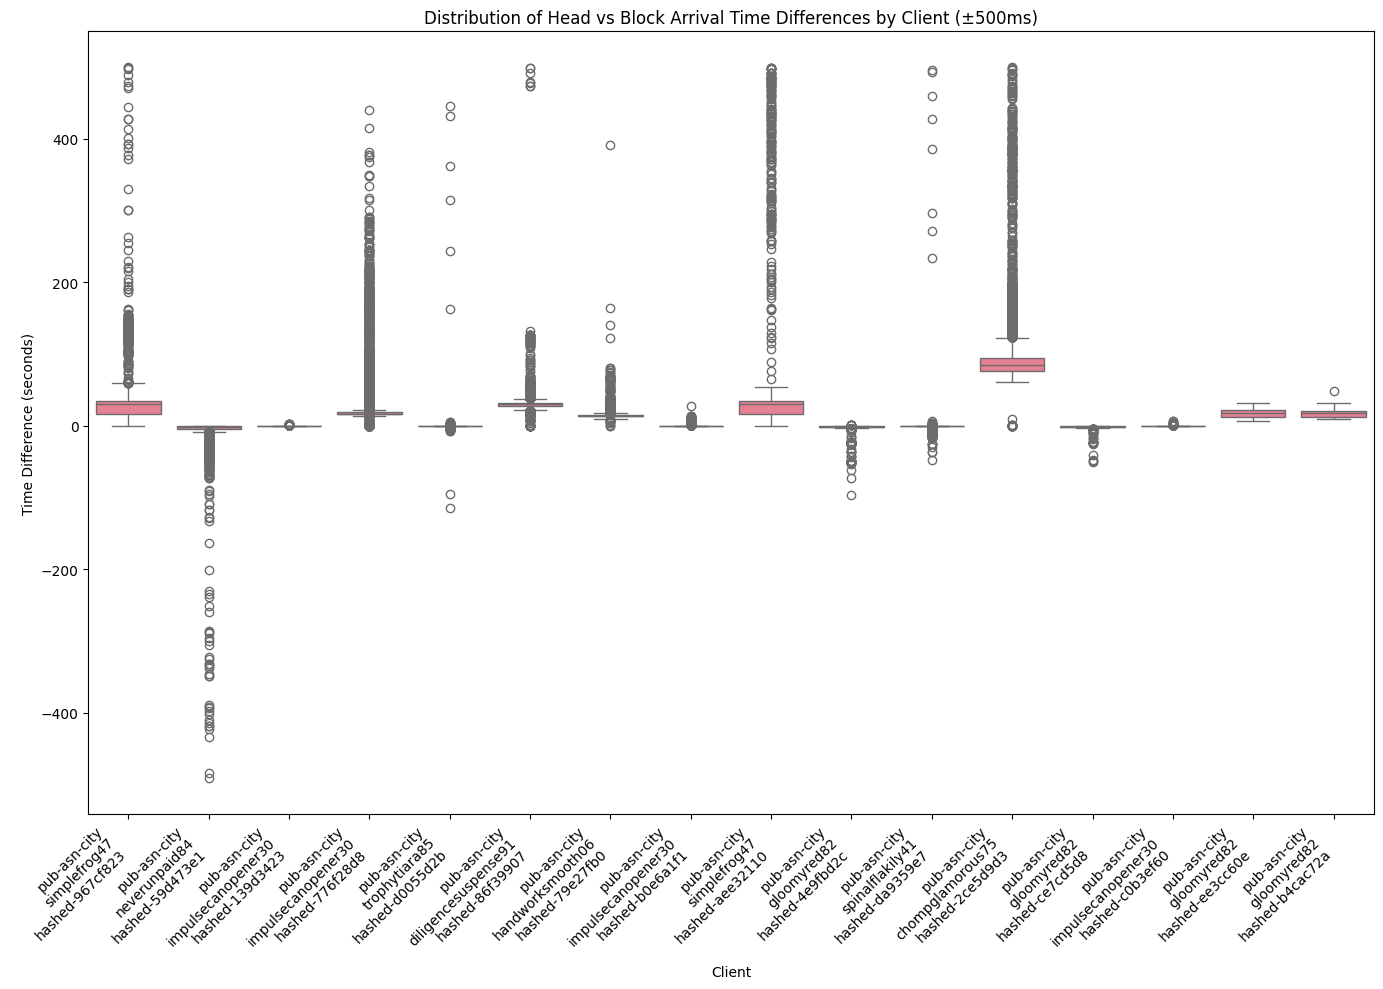

In [82]:
# Filter data
filtered_df = merged_df[(merged_df['arrival_diff'] <= 500) & (merged_df['arrival_diff'] >= -500) & (merged_df['client'] != '')]

# Create a figure with a larger size
plt.figure(figsize=(14, 10))

# Create box plot with client names split on multiple lines
sns.boxplot(data=filtered_df, x='client', y='arrival_diff')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Replace / with newlines in x-axis labels
labels = [label.get_text().replace('/', '\n') for label in plt.gca().get_xticklabels()]
plt.gca().set_xticklabels(labels)

# Customize the plot
plt.title('Distribution of Head vs Block Arrival Time Differences by Client (±500ms)')
plt.xlabel('Client')
plt.ylabel('Time Difference (seconds)')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


In [91]:
# Query for block events
block_query = text("""
    SELECT
        slot_start_date_time as time,
        min(propagation_slot_start_diff) as block_arrival_time,
        meta_consensus_implementation as client
    FROM beacon_api_eth_v1_events_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name NOT LIKE 'ethpandaops%'
        AND meta_client_name != ''
        AND meta_client_name IS NOT NULL
        AND meta_network_name = 'mainnet'
    GROUP BY time, client, slot
""")

# Query for head events
head_query = text("""
    SELECT
        slot_start_date_time as time,
        min(propagation_slot_start_diff) as head_arrival_time,
        meta_consensus_implementation as client
    FROM beacon_api_eth_v1_events_head FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name NOT LIKE 'ethpandaops%'
        AND meta_client_name != ''
        AND meta_client_name IS NOT NULL
        AND meta_network_name = 'mainnet'
    GROUP BY time, client, slot
""")

# Execute both queries
block_result = connection.execute(block_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
head_result = connection.execute(head_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})

# Convert results to DataFrames
block_df = pd.DataFrame(block_result.fetchall(), columns=['time', 'block_arrival_time', 'client'])
head_df = pd.DataFrame(head_result.fetchall(), columns=['time', 'head_arrival_time', 'client'])

# Drop rows with missing client values
block_df = block_df.dropna(subset=['client'])
head_df = head_df.dropna(subset=['client'])

# Merge the DataFrames
client_merged_df = pd.merge(block_df, head_df, on=['time', 'client'])

# Calculate the difference between head and block arrival times
client_merged_df['arrival_diff'] = client_merged_df['head_arrival_time'] - client_merged_df['block_arrival_time']

if len(client_merged_df) == 0:
    raise ValueError("No arrival times found for the given time range")

print(f"Found {len(client_merged_df)} arrival time differences for the given time range")



Found 581597 arrival time differences for the given time range


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_16036/3605591027.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(labels)


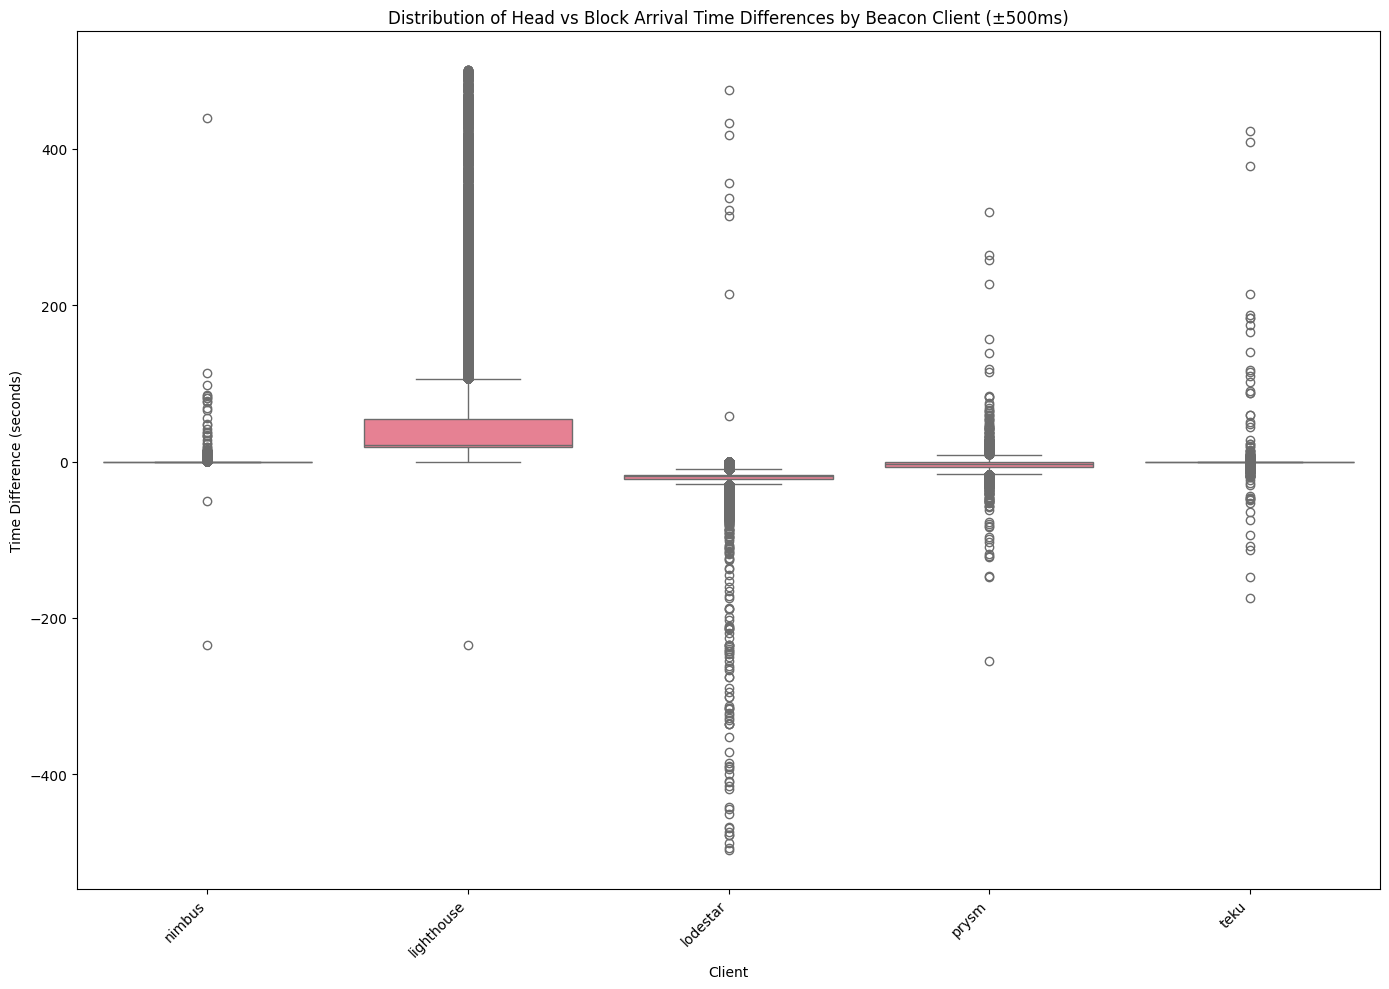

In [90]:
# Filter data
filtered_df = client_merged_df[(client_merged_df['arrival_diff'] <= 500) & (client_merged_df['arrival_diff'] >= -500) & (client_merged_df['client'] != '')]

# Create a figure with a larger size
plt.figure(figsize=(14, 10))

# Create box plot with client names split on multiple lines
sns.boxplot(data=filtered_df, x='client', y='arrival_diff')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Replace / with newlines in x-axis labels
labels = [label.get_text().replace('/', '\n') for label in plt.gca().get_xticklabels()]
plt.gca().set_xticklabels(labels)

# Customize the plot
plt.title('Distribution of Head vs Block Arrival Time Differences by Beacon Client (±500ms)')
plt.xlabel('Client')
plt.ylabel('Time Difference (seconds)')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


In [104]:
# Query for block events
block_query = text("""
    SELECT
        toDate(slot_start_date_time) as time,
        min(propagation_slot_start_diff) as min,
        max(propagation_slot_start_diff) as max,
        avg(propagation_slot_start_diff) as avg,
        quantile(0.95)(propagation_slot_start_diff) as p95,
        quantile(0.50)(propagation_slot_start_diff) as p50,
        quantile(0.05)(propagation_slot_start_diff) as p05

    FROM beacon_api_eth_v1_events_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name NOT LIKE 'ethpandaops%'
        AND meta_client_name != ''
        AND meta_client_name IS NOT NULL
        AND meta_network_name = 'mainnet'
    GROUP BY time
""")

result = connection.execute(block_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
block_df = pd.DataFrame(result.fetchall(), columns=['time', 'min', 'max', 'avg', 'p95', 'p50', 'p05'])

print(block_df)

          time  min         max            avg      p95     p50      p05
0   2024-10-04  828        8186    2479.299916  3795.40  2344.0  1693.60
1   2024-10-05  537       22655    2475.873147  3730.90  2362.0  1754.55
2   2024-10-06  554        6519    2473.519136  3682.00  2370.0  1737.55
3   2024-10-07  445      217050    2470.441534  3694.45  2348.0  1646.00
4   2024-10-08  199  4294967224  103043.034926  3588.45  2242.0  1616.00
5   2024-10-09  384       75331    2424.673128  3630.45  2241.0  1611.55
6   2024-10-10  193  4294967218   78707.798960  3700.90  2251.0  1627.55
7   2024-10-11  269       16790    2356.890920  3603.45  2215.0  1591.00
8   2024-10-12  420       27237    2382.223897  3654.45  2211.0  1593.55
9   2024-10-13  442       15379    2364.254754  3613.00  2209.0  1606.00
10  2024-10-14   81      142965    2414.731589  3683.45  2251.0  1620.55
11  2024-10-15  269       17326    2438.303535  3696.45  2280.0  1630.55
12  2024-10-16  498       24291    2425.502312  369

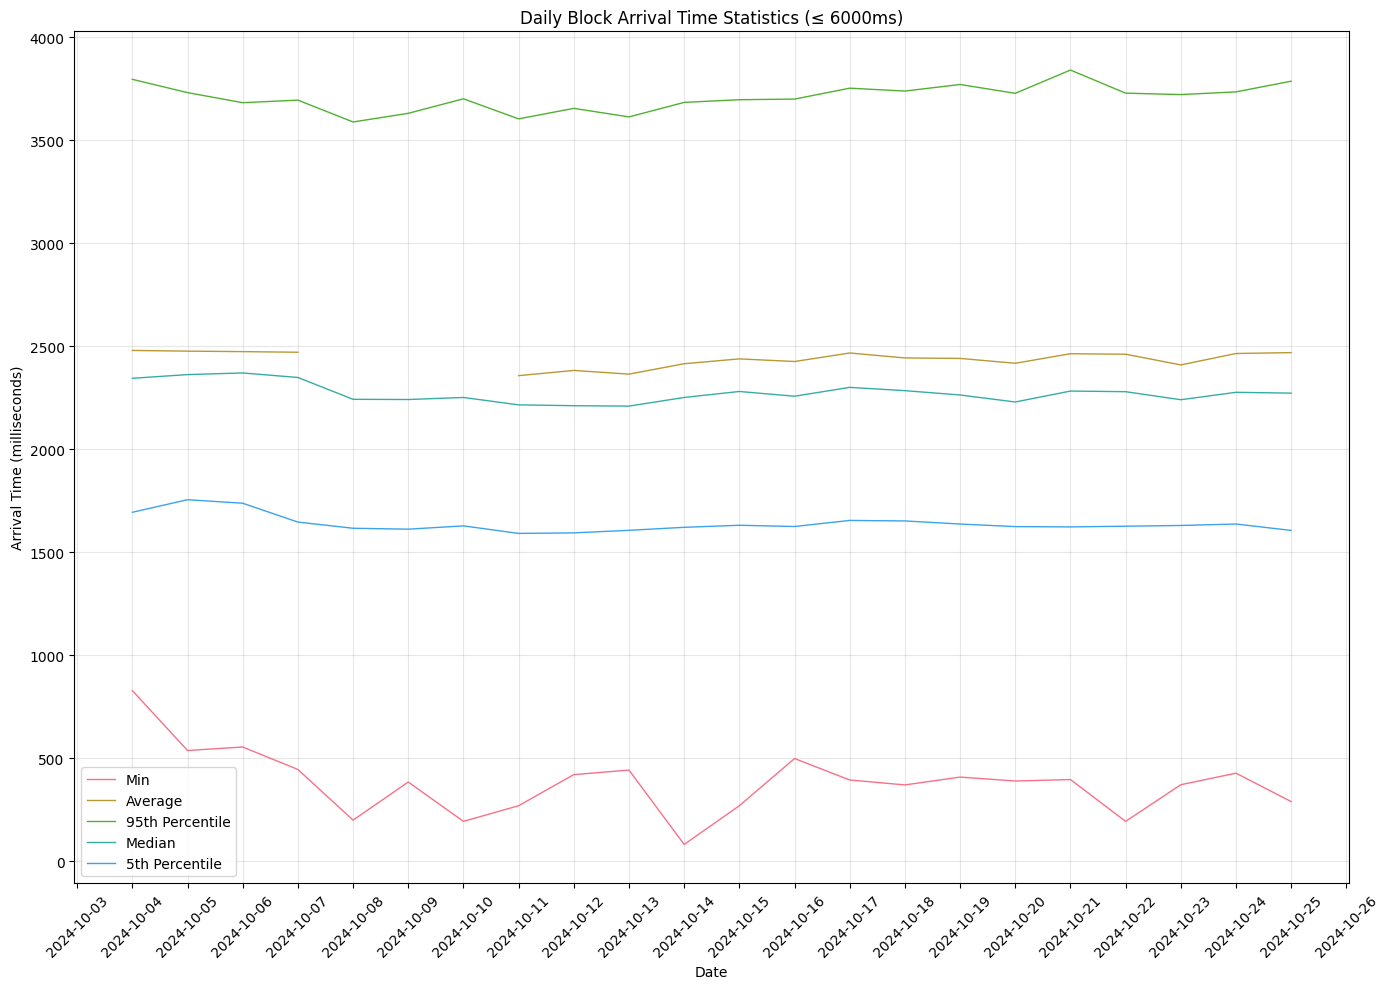

In [110]:
import matplotlib.dates as mdates

# Create figure and axis
plt.figure(figsize=(14, 10))

# Sort dataframe by time and convert to datetime
block_df = block_df.sort_values('time')
block_df['datetime'] = pd.to_datetime(block_df['time'])
block_df.set_index('datetime', inplace=True)

# Filter out values > 6000
block_df = block_df[block_df[['min', 'max', 'avg', 'p95', 'p50', 'p05']] <= 6000]

# Resample data to daily values
daily_df = block_df.resample('D').agg({
    'min': 'min',
    'max': 'max', 
    'avg': 'mean',
    'p95': 'mean',
    'p50': 'mean',
    'p05': 'mean'
})

# Plot all values
plt.plot(daily_df.index, daily_df['min'], label='Min', linewidth=1)
# plt.plot(daily_df.index, daily_df['max'], label='Max', linewidth=1)
plt.plot(daily_df.index, daily_df['avg'], label='Average', linewidth=1)
plt.plot(daily_df.index, daily_df['p95'], label='95th Percentile', linewidth=1)
plt.plot(daily_df.index, daily_df['p50'], label='Median', linewidth=1)
plt.plot(daily_df.index, daily_df['p05'], label='5th Percentile', linewidth=1)

# Customize the plot
plt.title('Daily Block Arrival Time Statistics (≤ 6000ms)')
plt.xlabel('Date')
plt.ylabel('Arrival Time (milliseconds)')
plt.legend()
plt.grid(True, alpha=0.3)

# Format x-axis to show dates nicely
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()
